# Dropout Regularization in Practice!

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Creating Non-linear dataset.
- This data is similar to the `qwerty` from previous projects.
- I'll call this data the `roundy` as a play on words.
- The solution will involve using basically a circle as a separator between the two datasets.

In [93]:
def create_dataset(number_per_cluster = 200):    
    # generating theta values, setting radius for each cluster
    theta = np.linspace(0, 4*np.pi, number_per_cluster) # interval [0, 4pi]
    radius_1 = 10
    radius_2 = 15

    # generating datasets
    cluster_a = [radius_1*np.cos(theta) + np.random.randn(number_per_cluster)*3,
                radius_1*np.sin(theta) + np.random.randn(number_per_cluster)]

    cluster_b = [radius_2*np.cos(theta) + np.random.randn(number_per_cluster),
                radius_2*np.sin(theta) + np.random.randn(number_per_cluster)*3]

    # hot encoding labels
    labels_np = np.vstack((np.zeros((number_per_cluster,1)), np.ones((number_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((cluster_a,cluster_b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels

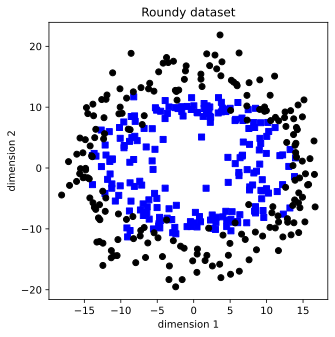

In [94]:
# creating dataset
round_data, round_labels = create_dataset()

# plotting dataset
# plotting data
fig = plt.figure(figsize=(5,5))

plt.plot(round_data[np.where(round_labels==0)[0],0], round_data[np.where(round_labels==0)[0],1], 'bs')
plt.plot(round_data[np.where(round_labels==1)[0],0], round_data[np.where(round_labels==1)[0],1], 'ko')

plt.title('Roundy dataset')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')

plt.show()

## Data Partitioning using `test_train_split`.

In [95]:
# dataset params
test_ratio = 0.2
batch_size = 16 # actually want this to be hard-coded, instead of a ratio of the dataset size

# splitting dataset into training and test set
training_data, test_data, training_labels, test_labels = train_test_split(round_data, round_labels, test_size= test_ratio)

# converting into torch dataset. Maintains relationship between data and labels before being randomly shuffled / sampled
training_dataset = TensorDataset(training_data, training_labels)
test_dataset = TensorDataset(test_data, test_labels)

# creating dataloader
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= test_dataset.tensors[0].shape[0]) # not testing in batches

print("Shape of training loader: ", next(iter(training_loader))[0].shape)
print("Shape of test loader: ", next(iter(test_loader))[0].shape)

Shape of training loader:  torch.Size([16, 2])
Shape of test loader:  torch.Size([80, 2])


### Model Class
- The model will include a parameter for dropout rate.
- Dropout Regularization will be implemented in the `forward` function in the class.
- The `self.training` attribute will automatically enable training when the model is set into training mode.
- Dropout is *not* applied to the output layer.

In [96]:
class categorical_nn(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        # layers
        self.input_layer = nn.Linear(2, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)

        # params
        self.drop_rate = dropout_rate

        # forward pass
    def forward(self, x):
        # input layer and dropout
        x = F.relu(self.input_layer(x))
        x = F.dropout(x, p=self.drop_rate, training=self.training) # enables if in training mode

        # hidden layer and dropout
        x = F.relu(self.hidden_layer(x))
        x = F.dropout(x, p=self.drop_rate, training=self.training)

        # output layer with NO dropout
        x = self.output_layer(x)

        return x

### Quick Model Test
- Mostly just testing for error messages here. It is much easier to fix mistakes at this step.

In [97]:
temp_net = categorical_nn(0.25)

temp_data = torch.randn((10,2))
temp_prediction = temp_net(temp_data)
temp_prediction # these numbers won't mean anything, as the network hasn't been trained yet

tensor([[-0.0765],
        [-0.2885],
        [-0.1877],
        [-0.0818],
        [-0.1619],
        [-0.3541],
        [-0.1080],
        [ 0.3325],
        [-0.1013],
        [ 0.0203]], grad_fn=<AddmmBackward0>)

## Class to create Models

In [98]:
def create_categorical_model(dropout_rate):

    # create instance of model class
    model = categorical_nn(dropout_rate)

    loss_function = nn.BCEWithLogitsLoss() # binary cross entropy loss

    optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

    return model, loss_function, optimizer

### Function to Train the Model
- Personal Note - make sure the `return` is outside of any loops.

In [99]:
def train_model(model, loss_function, optimizer, number_epochs = 1000):

    # initialize accuracy arrays
    training_accuracy = []
    test_accuracy = []

    # loop through epochs
    for epoch_IDX in range(number_epochs):

        # enable training mode
        model.train()

        # loop through batches of training data
        batch_accuracy = []

        for data, labels in training_loader:

            # forward pass and loss
            y_hat = model(data)
            loss = loss_function(y_hat, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculating batch accuracy
            batch_accuracy.append(100*torch.mean(((y_hat>0) == labels).float()).item())

        # calculating accuracy for epoch
        training_accuracy.append(np.mean(batch_accuracy))

        # testing model (no training or learning)
        model.eval()
        data,labels = next(iter(test_loader))
        y_hat = model(data)

        # calculating accuracy for test set
        test_accuracy.append(100*torch.mean(((y_hat>0)==labels).float()).item())

    return training_accuracy, test_accuracy

### Testing Model creation Class and Training Function

In [100]:
# test params
dropout_rate = 0.0 # dropout rate is 0
ANN_classify, loss_function, optimizer = create_categorical_model(dropout_rate)

training_accuracy, test_accuracy = train_model(ANN_classify, loss_function, optimizer, number_epochs=1000)

#print(f"Shape of training accuracy:", np.shape(training_accuracy))
#print(f"Shape of test accuracy:", np.shape(test_accuracy))

## Creating Graph smoothing filter

In [101]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

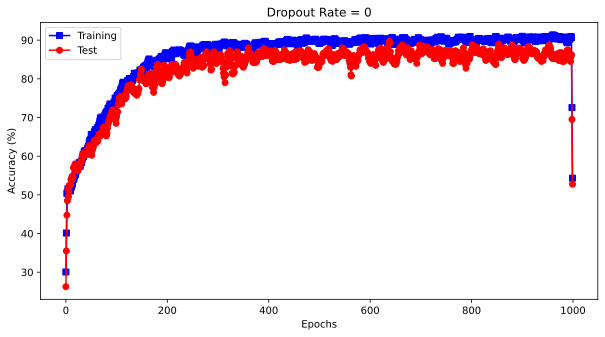

In [102]:
# plotting results of test
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(training_accuracy), 'bs-')
plt.plot(smooth(test_accuracy), 'ro-')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Training', 'Test'])
plt.title('Dropout Rate = %g'%dropout_rate)

plt.show()

### Interpreting the results:
- If the accuracy graphed is super choppy, it indicates that the training batch size is too small.
- A common graphing trick is to 'smooth' out the output with a smoothing filter. 
    - The one in this project utilizes convolution to convolve the input with a vector of ones.

---
# Parametric Experiment!
- The dropout rate will be parametrically varied to see how it affects model accuracy.

In [103]:
# experiment params
dropout_rates = np.arange(10)/10
results_array = np.zeros((len(dropout_rates), 2))

for drop_IDX in range(len(dropout_rates)):
    # creating and training model
    ANN_classify, loss_function, optimizer = create_categorical_model(dropout_rates[drop_IDX])
    training_accuracy, test_accuracy = train_model(ANN_classify, loss_function, optimizer, number_epochs=1000)

    # calculating accuracy from the last 100 epochs of training (better data points)
    results_array[drop_IDX, 0] = np.mean(training_accuracy[-100:])
    results_array[drop_IDX, 1] = np.mean(test_accuracy[-100:])

Text(0, 0.5, 'Train-test difference (accuracy%)')

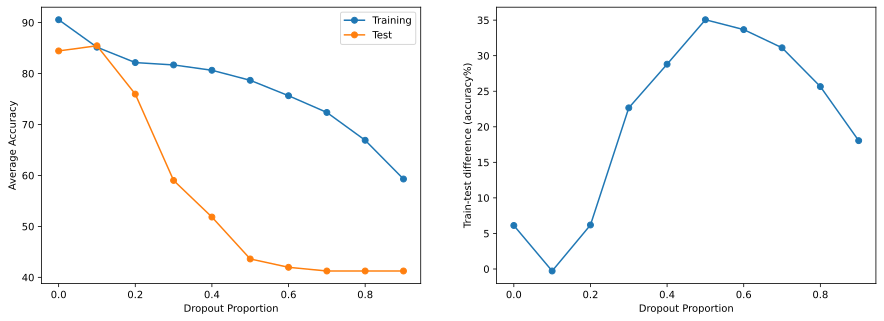

In [104]:
# plotting results
fig,ax = plt.subplots(1, 2, figsize=(15,5))

# training and testing accuracy
ax[0].plot(dropout_rates, results_array, 'o-')
ax[0].set_xlabel('Dropout Proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Training', 'Test'])

# difference between training and testing accuracy
ax[1].plot(dropout_rates, -np.diff(results_array, axis=1), 'o-')
ax[1].set_xlabel('Dropout Proportion')
ax[1].set_ylabel('Train-test difference (accuracy%)')

### Interpreting the Results
#### The first plot measures model **accuracy** (training and testing) vs the **proportion of dropout**.
- Both training and testing accuracies are negatively affected, especially when the dropout is increased to the extreme of 70%-90%. In this case it didn't help with the model's accuracy hardly at all.
- It would definitely be good in future projects to study the behavior of the model before applying any regularization method.
- I suspect that the dataset is still too small to see the benefits of regularization.

#### In the second plot, the **generalizability** *(difference between training and testing accuracies)* of the model is assessed  vs the **proportion of dropout**.
- Values closer to zero are desired for this plot, indicating that the model isn't having problems with generalizability.
- The larger the difference, the more overfitted the model is to the training data.
- It is interesting that towards greater amounts of dropout (upwards of 80%), the difference between the accuracies is actually smaller. 
    - This is because the model has poor accuracy in both testing and training.
    - I guess this means that a smaller difference isn't the only measure of a successful model.
    - Don't rely just on this metric to determine if the model is training well.
- There will be a **smaller difference** if the accuracies are *similar*, both are either doing well or horrible.